# Example notebook

In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colormaps
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model     
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.loaders.svg_loader import FloorplanSVGSample

from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid
import panel as pn
from PIL import Image, ImageDraw

pn.extension()

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]


In [2]:
target_dir = Path('runs_cubi/2024-08-07-19:51:00')

In [3]:
def custom_collate(input_values: tuple[FloorplanSVGSample, ...], *rest):
    return FloorplanSVGSample(
        image=torch.stack(tuple(x.image for x in input_values)),
        label=torch.stack(tuple(x.label for x in input_values)),
    )
data_folder = Path('data/cubicasa5k/')
data_file = 'test.txt'
n_classes = 44
split = [21, 12, 11]
n_rooms = 12
n_icons = 11
def setup_model(target_file = 'model_best_val_loss_var.pkl'):
    normal_set = FloorplanSVG(data_folder, data_file, format='lmdb', original_size=True)
    data_loader = DataLoader(normal_set, batch_size=1, num_workers=0, collate_fn=custom_collate)
    data_iter = iter(data_loader)
    # Setup Model
    model = get_model('hg_furukawa_original', 51)

    
    model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
    model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
    checkpoint = torch.load(
        target_dir / target_file, map_location=torch.device('cpu')
    )

    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    # model.cuda()
    print("Model loaded.")
    return model, data_iter

In [4]:
def fetch_sample(data_iter):
    val = next(data_iter)
    junctions = val.heatmaps
    # folder = val.folder[0]
    image = val.image
    label = val.label
    np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
    return image, label, np_img, junctions

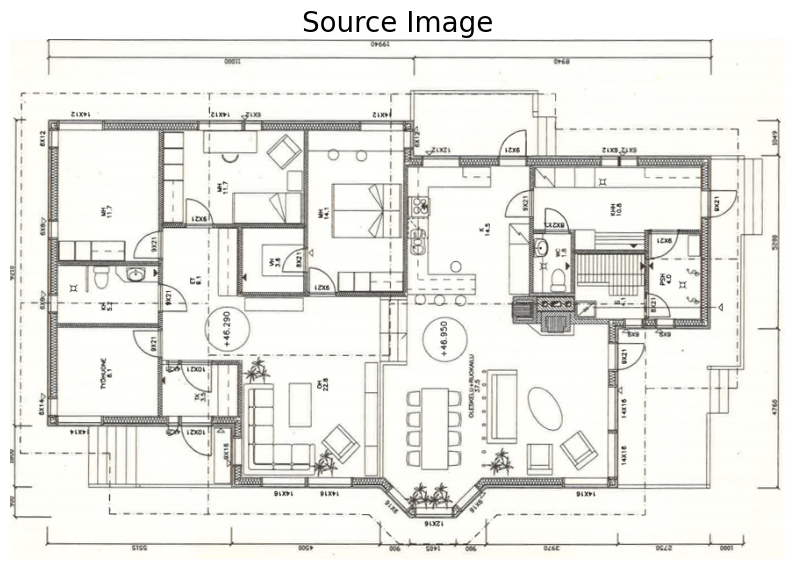

In [13]:

plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [3]:
from IPython.display import Image
from IPython.core.display import HTML   
Image(url= data_folder+folder+"model.svg", width=800)

## Parsed labels

In [5]:
def parse_labels(label, np_img, junctions = None):
    label_np = label.data.numpy()[0]
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1)
    plt.title('Rooms and walls', fontsize=20)
    ax.axis('off')
    rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
    cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
    cbar.ax.set_yticklabels(room_classes, fontsize=20)
    plt.close(fig)
    rooms_and_walls_pane = pn.pane.Matplotlib(fig, dpi=144, tight=True, width=400)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1)
    plt.title('Icons', fontsize=20)
    ax.axis('off')
    iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
    cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
    cbar.ax.set_yticklabels(icon_classes, fontsize=20)
    plt.close(fig)
    icons_pane = pn.pane.Matplotlib(fig, dpi=144, tight=True, width=400)
    fig = plt.figure(figsize=(10,10))
    try:
        ax = plt.subplot(1, 1, 1)
        plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
        ax.axis('off')
        ax.imshow(np_img)
        h, w, _ = np_img.shape
        draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
        plt.close(fig)
        junctions_pane = pn.pane.Matplotlib(fig, dpi=144, tight=True, width=400)
        return rooms_and_walls_pane, icons_pane, junctions_pane
    except Exception as e:
        # TODO: get junction parsing working again
        print(e)
        plt.close(fig)
    return rooms_and_walls_pane, icons_pane

## Networks prediction for the segmentation

In [6]:
def run_segmentation(model, image, label):
    label_np = label.data.numpy()[0]
    with torch.no_grad():
        height = label_np.shape[1]
        width = label_np.shape[2]
        img_size = (height, width)
        
        rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
        pred_count = len(rotations)
        prediction = torch.zeros([pred_count, n_classes, height, width])
        for i, r in enumerate(rotations):
            forward, back = r
            # We rotate first the image
            rot_image = rot(image, 'tensor', forward)
            pred = model(rot_image)
            # We rotate prediction back
            pred = rot(pred, 'tensor', back)
            # We fix heatmaps
            pred = rot(pred, 'points', back)
            # We make sure the size is correct
            pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
            # We add the prediction to output
            prediction[i] = pred[0]

    prediction = torch.mean(prediction, 0, True)
    rooms_label = label_np[0]
    icons_label = label_np[1]

    rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
    rooms_pred = np.argmax(rooms_pred, axis=0)

    icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
    icons_pred = np.argmax(icons_pred, axis=0)
    rooms_cmap = colormaps.get('rooms')
    rooms_im = Image.fromarray((rooms_cmap(rooms_pred) * 255).astype(np.uint8))
    # plt.figure(figsize=(12,12))
    # ax = plt.subplot(1, 1, 1)
    # ax.axis('off')
    # rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
    # cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
    # cbar.ax.set_yticklabels(room_classes, fontsize=20)
    # plt.show()
    icons_cmap = colormaps.get('icons')
    icons_im = Image.fromarray((icons_cmap(icons_pred) * 255).astype(np.uint8))
    return rooms_im, icons_im, prediction, img_size
    # plt.figure(figsize=(12,12))
    # ax = plt.subplot(1, 1, 1)
    # ax.axis('off')
    # iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
    # cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
    # cbar.ax.set_yticklabels(icon_classes, fontsize=20)
    # plt.show()


In [7]:
def run_all(target_file = 'model_best_val_loss_var.pkl'):
    model, data_iter = setup_model(target_file)
    image, label, np_img, junctions = fetch_sample(data_iter)
    rooms_im, icons_im, prediction, img_size = run_segmentation(model, image, label)
    room_pane, icon_pane = pn.pane.Image(rooms_im, width=400), pn.pane.Image(icons_im, width=400)
    return room_pane, icon_pane, prediction, img_size

In [8]:
def run_ground_truth(target_file = 'model_best_val_loss_var.pkl'):
    model, data_iter = setup_model(target_file)
    image, label, np_img, junctions = fetch_sample(data_iter)
    return parse_labels(label, np_img, junctions)

In [9]:
target_files = list(
    map(lambda x: x.name, sorted(
        target_dir.glob('model_epoch_*.pkl'),
        key=lambda x: int(re.search(r'model_epoch_(\d+)', x.stem).group(1))
    ))
) + ['model_best_val_loss_var.pkl']

In [10]:
layout = pn.FlexBox(flex_direction='row', flex_wrap='wrap')
ground_truth_panes = run_ground_truth()
layout.append(pn.Column("Ground truth", *ground_truth_panes))
layout

Model loaded.
'NoneType' object has no attribute 'items'


BokehModel(combine_events=True, render_bundle={'docs_json': {'c3a7d4eb-4fdf-41fc-95ce-d41aba445f85': {'version…

In [11]:
for target_file in target_files:
    res = run_all(target_file)
    layout.append(pn.Column(target_file, *res[:2]))

Model loaded.
Model loaded.
Model loaded.
Model loaded.
Model loaded.


KeyboardInterrupt: 

## Post-processed polygons

In [37]:

def run_post_processed_polygons(prediction, img_size):
    height, width = img_size
    heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
    print(heatmaps.shape, rooms.shape, icons.shape)
    polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

    pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
    plt.figure(figsize=(12,12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
    cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
    cbar.ax.set_yticklabels(room_classes, fontsize=20)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
    cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
    cbar.ax.set_yticklabels(icon_classes, fontsize=20)
    plt.tight_layout()
    plt.show()

In [39]:
rooms_pane, icons_pane, prediction, img_size = run_all()

Model loaded.


In [40]:
run_post_processed_polygons(prediction, img_size)

(21, 592, 883) (12, 592, 883) (11, 592, 883)


IndexError: invalid index to scalar variable.

## Ground truth and prediction comparisons

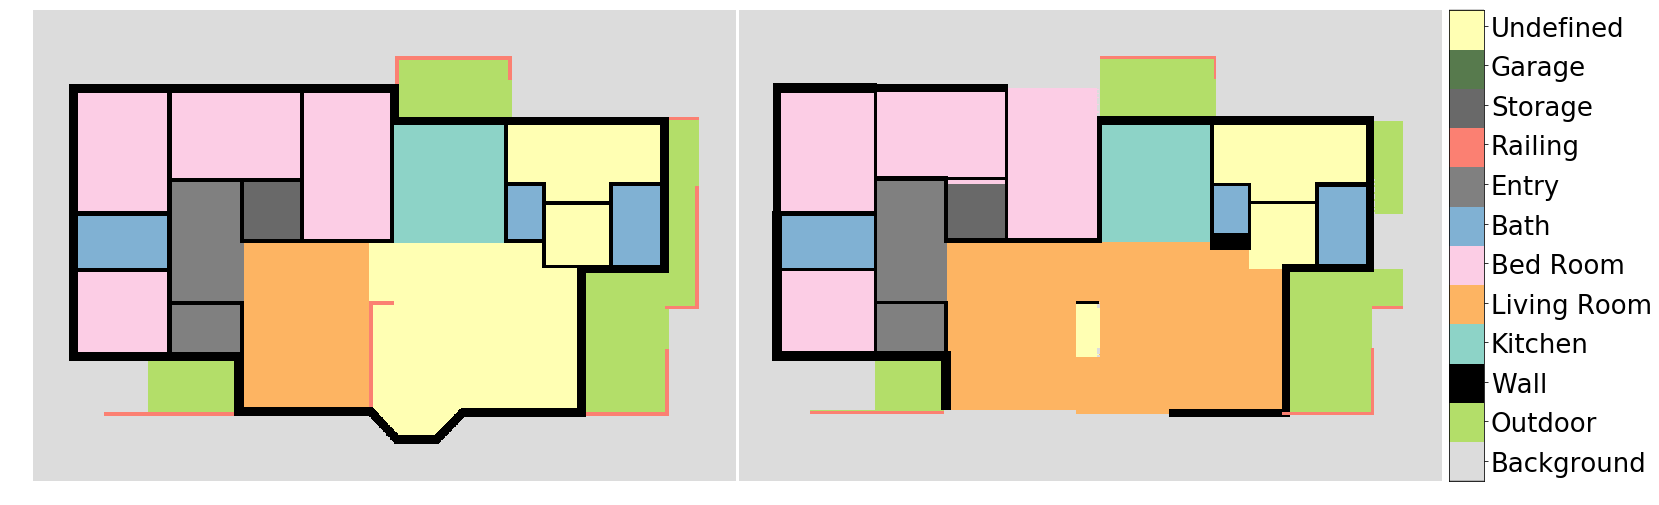

In [7]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
images = [label_np[0], pol_room_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = ax.cax.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5)
cbar.ax.set_yticklabels(room_classes, fontsize=26)
plt.show()

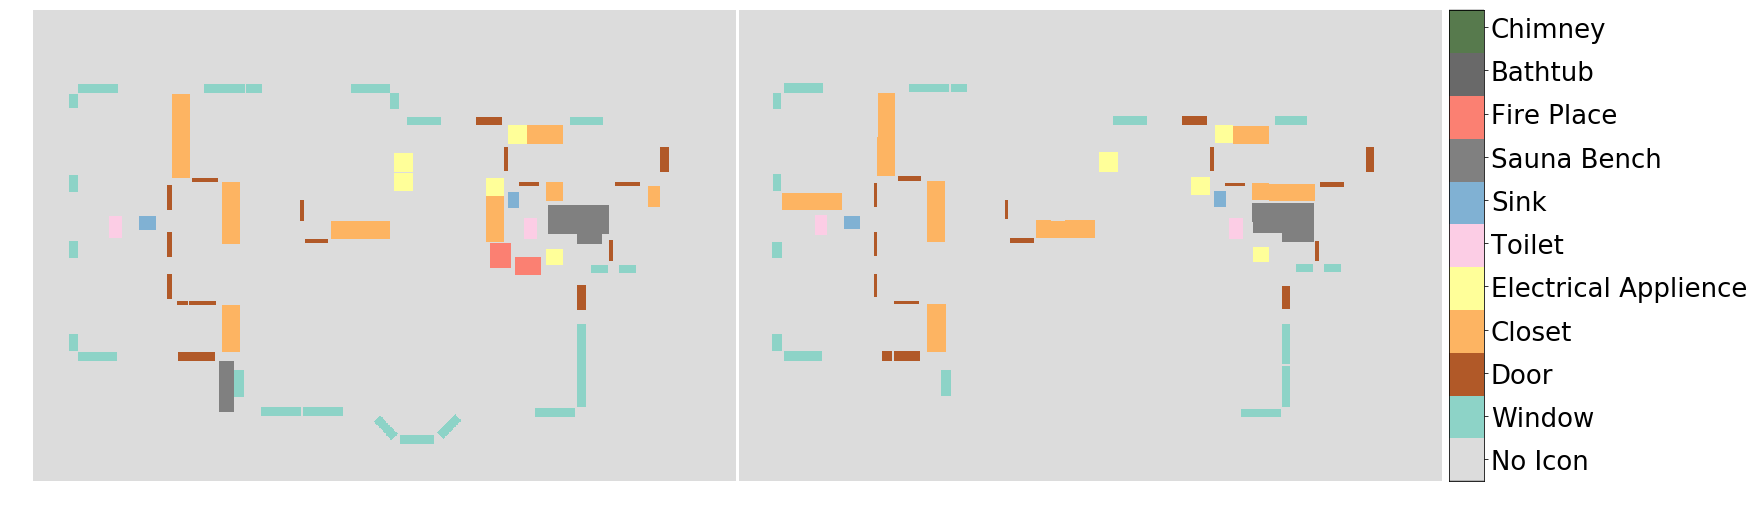

In [8]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

images = [label_np[1], pol_icon_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='icons', vmin=0, vmax=n_icons-0.1)

cbar = ax.cax.colorbar(iseg, ticks=np.arange(n_icons) + 0.5)
cbar.ax.set_yticklabels(icon_classes, fontsize=26)
plt.show()